In [133]:
import numpy as np, scipy as sp, sklearn as sk, pandas as pd
from matplotlib import pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

## import data ##

In [2]:
df = pd.read_csv('/Users/billy/Desktop/uber2.csv', parse_dates=['Date/Time'])
for i in range(3,5):
    df = pd.concat([df, pd.read_csv('/Users/billy/Desktop/uber' + str(i) + '.csv', 
                                    parse_dates=['Date/Time'])], axis=0)
df.shape

(2112400, 4)

## some brief exploration ##

daily data does not look near as interesting as hourly

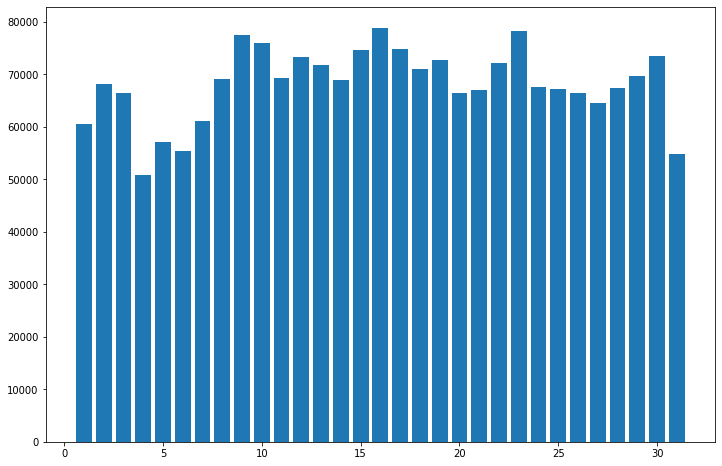

In [79]:
df['Day'] = df['Date/Time'].dt.day
day_pivot = df.pivot_table(index=['Day'], values='Base',aggfunc='count')
plt.figure(figsize=(12,8))
plt.bar(day_pivot.index, day_pivot.Base)
plt.show()

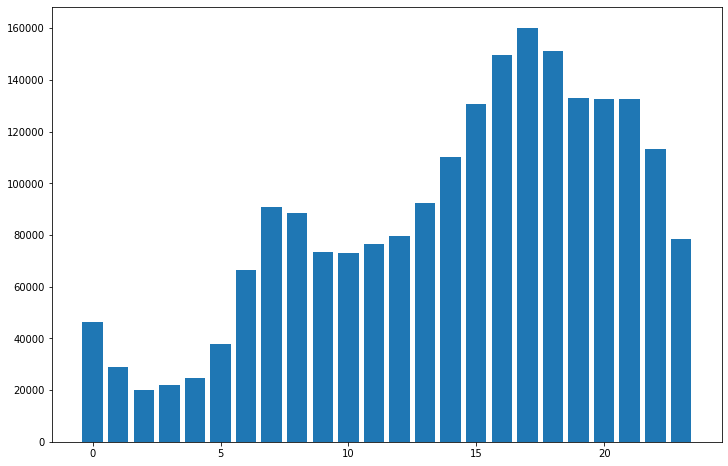

In [78]:
df['Hour'] = df['Date/Time'].dt.hour
hour_pivot = df.pivot_table(index=['Hour'], values='Base', aggfunc='count')
plt.figure(figsize=(12,8))
plt.bar(hour_pivot.index, hour_pivot.Base)
plt.show()

## "feature engineering" ##

In [31]:
hourly  = pd.DataFrame()
hourly['ride_count'] = df['Date/Time'].value_counts().resample('H').sum()
hourly['log_count'] = hourly.transform(np.log)
hourly['delta'] = hourly['ride_count'].diff()
hourly['log_delta'] = hourly['log_count'].diff()
hourly = hourly.dropna()

## stationary? yes, thank god ##

p-value < 0.05, we can assume stationarity with a confidence level that's well above 95%

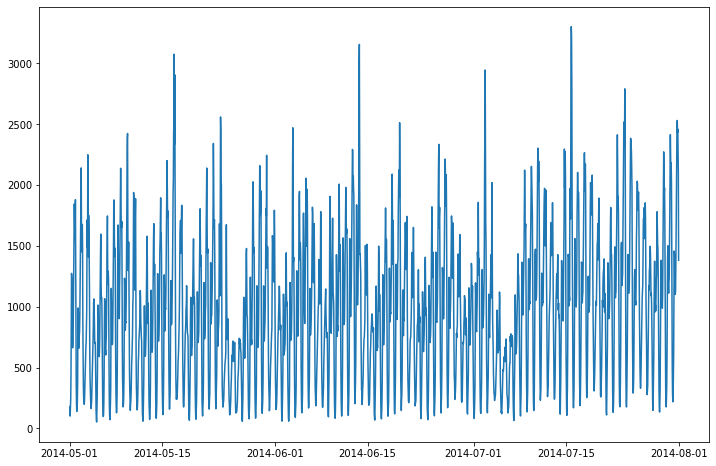

In [77]:
plt.figure(figsize=(12,8))
plt.plot(hourly.ride_count)
plt.show()

In [70]:
#dickey fuller test

print('p-value: {}'.format(adfuller(hourly.ride_count)[1]))

p-value: 0.006890339417604814


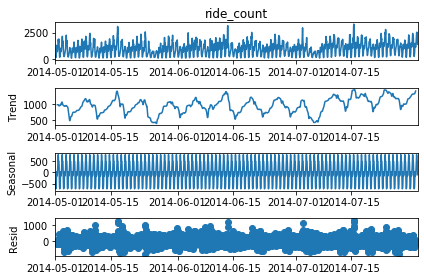

In [29]:
sm.tsa.seasonal_decompose(hourly.ride_count).plot()
result = sm.tsa.stattools.adfuller(hourly.ride_count)
plt.show()

## acf parameter: 5 / pacf parameter: 3 ##

this actually ends up being an ARMA model because no differencing

<Figure size 864x576 with 0 Axes>

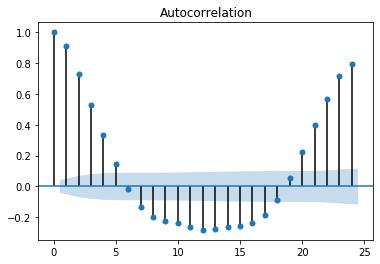

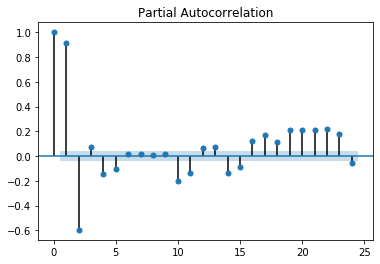

In [76]:
plt.figure(figsize=(12,8))
plot_acf(hourly.ride_count, lags = 24)
plot_pacf(hourly.ride_count, lags = 24)
plt.show()

## train / test split ##

In [71]:
train = hourly[1:int(len(hourly)*.8)]
test = hourly[int(len(hourly)*.8):]

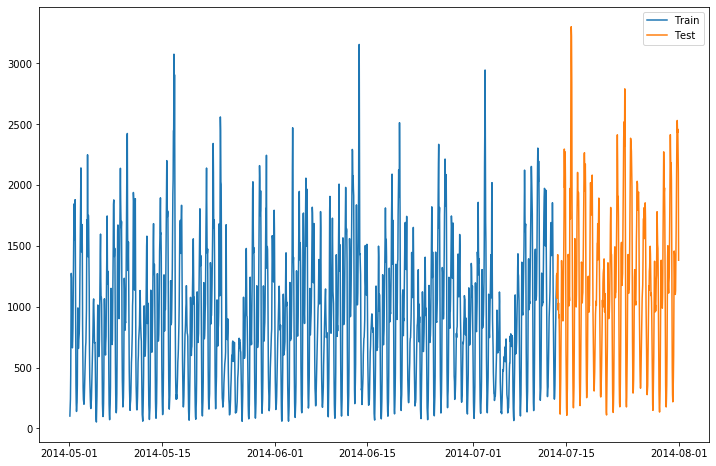

In [132]:
plt.figure(figsize=(12,8))
plt.plot(train.index, train.ride_count, label='Train')
plt.plot(test.index, test.ride_count, label='Test')
plt.legend(loc='best')
plt.show()

## models ##

In [33]:
def rmse(x,y):
    return np.sqrt(mean_squared_error(x,y))

## baseline: naive model ##

$\hat{y}_{t+1} = y$

In [74]:
naive = np.array(train.ride_count)
y_hat = test.copy()
y_hat['naive'] = naive[len(naive)-1]

RMSE:  642.4706888044393


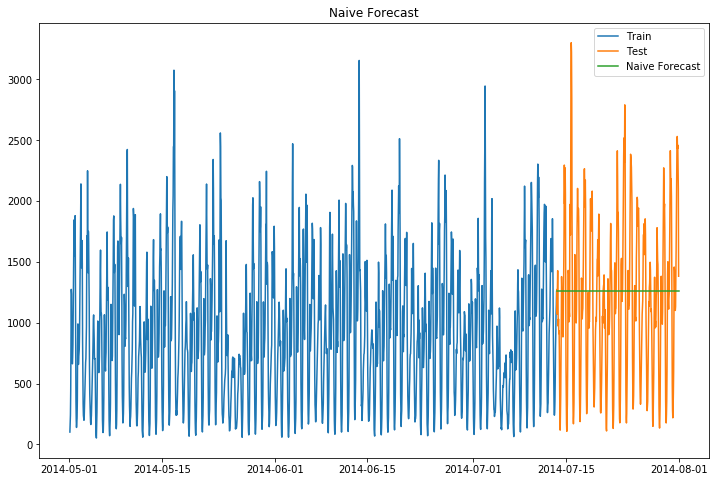

In [81]:
print('RMSE: ',rmse(test.ride_count, y_hat.naive))
plt.figure(figsize=(12,8))
plt.plot(train.index, train.ride_count, label='Train')
plt.plot(test.index, test.ride_count, label='Test')
plt.plot(y_hat.index, y_hat.naive, label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

## holt-winters (triple exponential smoothing) ##

rather than brute force a grid search for hyperparameter optimization, we opt for an iterative process

additive method is preferred when the seasonal variations are roughly constant through the series, while the multiplicative method is preferred when the seasonal variations are changing proportional to the level of the series.

In [116]:
model = ExponentialSmoothing(train.ride_count, seasonal='add', seasonal_periods=24).fit()
pred = model.predict(start=test.ride_count.index[0], end=test.ride_count.index[-1])

/Users/billy/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [117]:
model.summary()

Dep. Variable:,endog,No. Observations:,1764
Model:,ExponentialSmoothing,SSE,54088146.240
Optimized:,True,AIC,18275.507
Trend:,None,BIC,18417.866
Seasonal:,Additive,AICC,18276.443
Seasonal Periods:,24,Date:,"Sat, 07 Mar 2020"
Box-Cox:,False,Time:,16:55:55
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9473684,alpha,True
smoothing_seasonal,0.0526316,gamma,True


RMSE:  357.2674521220561


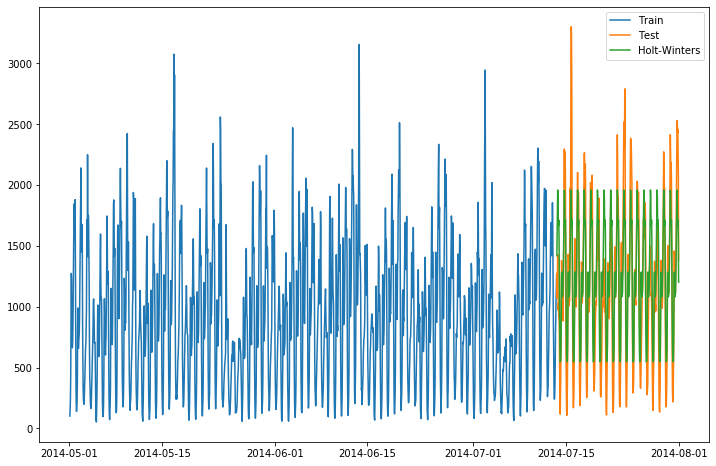

In [118]:
print('RMSE: ',rmse(test.ride_count, pred))
plt.figure(figsize=(12,8))
plt.plot(train.ride_count.index, train.ride_count, label='Train')
plt.plot(test.ride_count.index, test.ride_count, label='Test')
plt.plot(pred.index, pred, label='Holt-Winters')
plt.legend(loc='best')
plt.show()

## ARIMA ##

In [146]:
model = ARIMA(train.ride_count, order=(2, 0, 5)).fit(disp=-24) 
pred = model.predict(start=test.ride_count.index[0], end=test.ride_count.index[-1], dynamic=True)

RMSE:  695.5711586713527


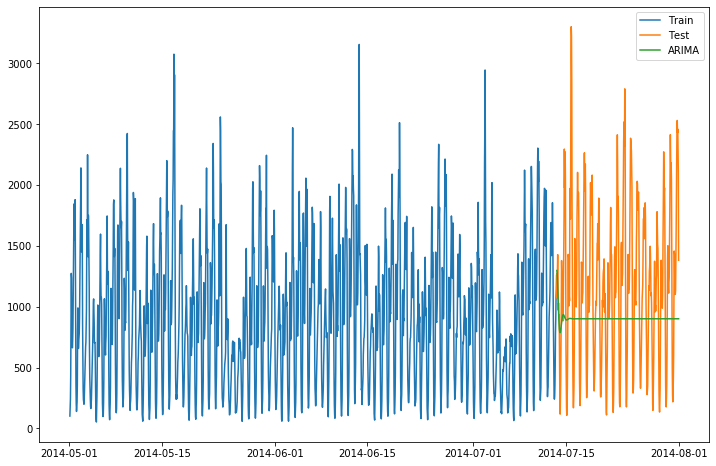

In [147]:
print('RMSE: ',rmse(test.ride_count, pred))
plt.figure(figsize=(12,8))
plt.plot(train.ride_count.index, train.ride_count, label='Train')
plt.plot(test.ride_count.index, test.ride_count, label='Test')
plt.plot(pred.index, pred, label='ARIMA')
plt.legend(loc='best')
plt.show()

In [144]:
model = sm.tsa.statespace.SARIMAX(train.ride_count, order=(2, 0, 5),seasonal_order=(0,1,1,7)).fit()
pred = model.predict(start=test.ride_count.index[0], end=test.ride_count.index[-1], dynamic=True)

RMSE:  698.0208531731432


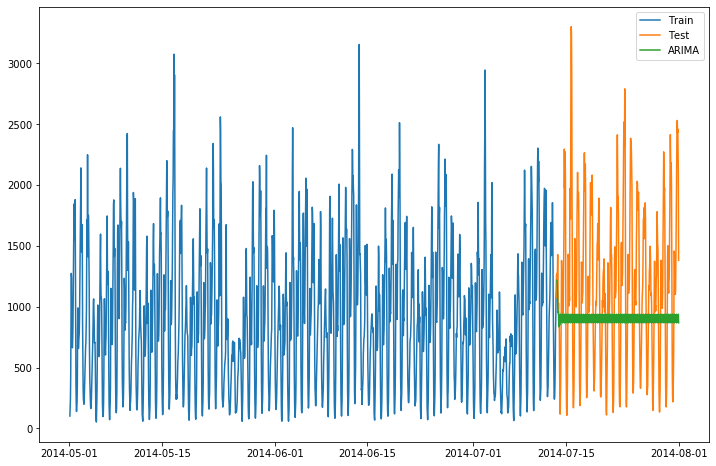

In [145]:
print('RMSE: ',rmse(test.ride_count, pred))
plt.figure(figsize=(12,8))
plt.plot(train.ride_count.index, train.ride_count, label='Train')
plt.plot(test.ride_count.index, test.ride_count, label='Test')
plt.plot(pred.index, pred, label='ARIMA')
plt.legend(loc='best')
plt.show()